#### Private Work - Not for Presentation 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [27]:
def refine_arima_parameters(data):
    """
    Function to refine ARIMA parameters using ADF test, ACF and PACF plots, and grid search with AIC and BIC.
    
    Args:
    - data (pd.Series): Time series data.
    
    Returns:
    - Optimal p, d, q values for ARIMA model.
    """
    
    # ADF Test for stationarity
    adf_result = adfuller(data)
    if adf_result[1] <= 0.05:  # p-value
        d = 0
    else:
        d = 1
    
    # ACF and PACF plots
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(data, lags=20, ax=plt.gca())
    plt.title('ACF Plot')
    
    plt.subplot(122)
    plot_pacf(data, lags=20, ax=plt.gca())
    plt.title('PACF Plot')
    plt.tight_layout()
    plt.show()
    
    # Using heuristic from ACF and PACF plots for initial p and q values
    p = 1  # Assuming AR(1) from PACF plot
    q = 1  # Assuming MA(1) from ACF plot
    
    best_aic = np.inf
    best_bic = np.inf
    best_order_aic = (p, d, q)
    best_order_bic = (p, d, q)
    
    # Grid search for p and q values
    for p in range(3):
        for q in range(3):
            try:
                model = ARIMA(data, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order_aic = (p, d, q)
                if model_fit.bic < best_bic:
                    best_bic = model_fit.bic
                    best_order_bic = (p, d, q)
            except:
                continue
                
    # Average rank based on AIC and BIC
    orders = [(p, d, q) for p in range(3) for q in range(3)]
    aic_values = [ARIMA(data, order=order).fit().aic for order in orders]
    bic_values = [ARIMA(data, order=order).fit().bic for order in orders]
    
    aic_ranks = np.argsort(aic_values)
    bic_ranks = np.argsort(bic_values)
    
    avg_rank = (aic_ranks + bic_ranks) / 2
    best_avg_rank_order = orders[np.argmin(avg_rank)]
    
    print(f"Best order based on AIC: {best_order_aic}")
    print(f"Best order based on BIC: {best_order_bic}")
    print(f"Best order based on average rank: {best_avg_rank_order}")
    
    return best_avg_rank_order




In [28]:
def manual_rainfall_shock_simulation_refined_v2(data_path, sensor_name, rainfall_mm=30, forecast_steps=150):
    """
    Simulate and visualize the immediate impact of a specified amount of rainfall on soil moisture
    using an ARIMA model for forecasting with refined parameters.
    
    Args:
    - data_path (str): Path to the dataset.
    - sensor_name (str): Name of the sensor to analyze.
    - rainfall_mm (float): Amount of rainfall (in mm) to simulate.
    - forecast_steps (int): Number of steps to forecast.
    
    Returns:
    - ARIMA model, forecasted values with rainfall shock, and a visualization of the data and forecast.
    """
    
    # Load and preprocess the data
    data = pd.read_csv(data_path)
    data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
    data = data.dropna(subset=['datetime'])
    data = data[data['sensorname'] == sensor_name]
    data = data.sort_values(by='datetime')
    
    # Fit ARIMA model with refined parameters
    optimal_order = refine_arima_parameters(data['valueMeasurement'])
    model = ARIMA(data['valueMeasurement'], order=optimal_order)
    model_fit = model.fit()
    print(optimal_order)
    # Forecast using the ARIMA model
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Introduce the rainfall shock
    forecast_with_shock = forecast.copy()
    forecast_with_shock.iloc[0] += rainfall_mm  # Using iloc to access the first forecasted value
    
    # Plot the observed and forecasted data
    plt.figure(figsize=(12, 6))
    plt.plot(data['datetime'], data['valueMeasurement'], label='Observed', color='blue')
    forecast_dates = [data['datetime'].iloc[-1] + pd.Timedelta(minutes=i+1) for i in range(forecast_steps)]
    plt.plot(forecast_dates, forecast_with_shock, 'r--', label='Forecast with Rainfall Shock', marker='o')
    plt.title(f'Impact of {rainfall_mm}mm Rainfall on {sensor_name} Soil Moisture. Shock value of {rainfall_mm}mm.')
    plt.xlabel('Datetime')
    plt.ylabel('Soil Moisture Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return model_fit, forecast_with_shock

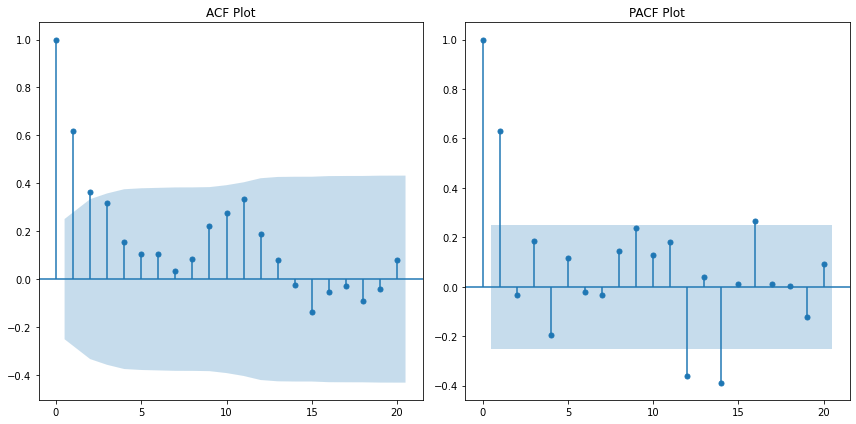

Best order based on AIC: (1, 0, 0)
Best order based on BIC: (1, 0, 0)
Best order based on average rank: (2, 0, 2)
(2, 0, 2)


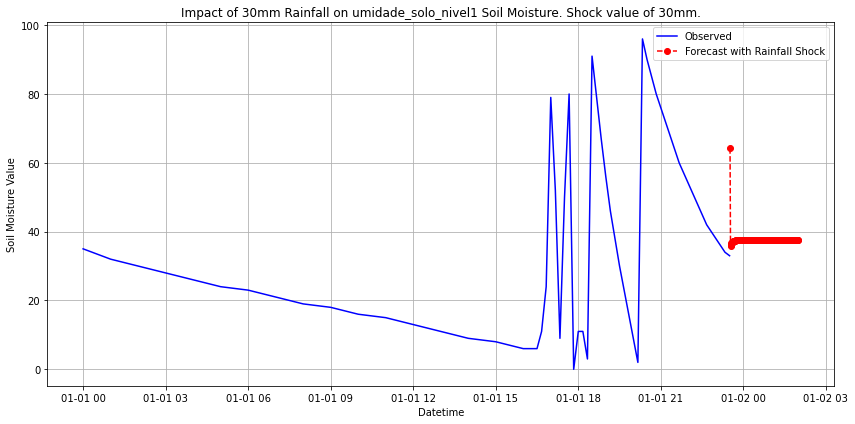

In [29]:
model_fit, forecast_with_shock = manual_rainfall_shock_simulation_refined_v2('newData.csv', 'umidade_solo_nivel1')


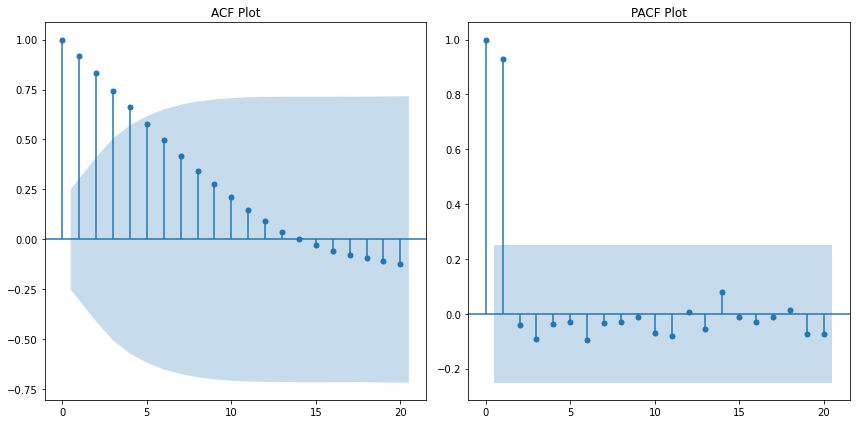

Best order based on AIC: (2, 1, 1)
Best order based on BIC: (1, 1, 1)
Best order based on average rank: (2, 1, 2)
(2, 1, 2)


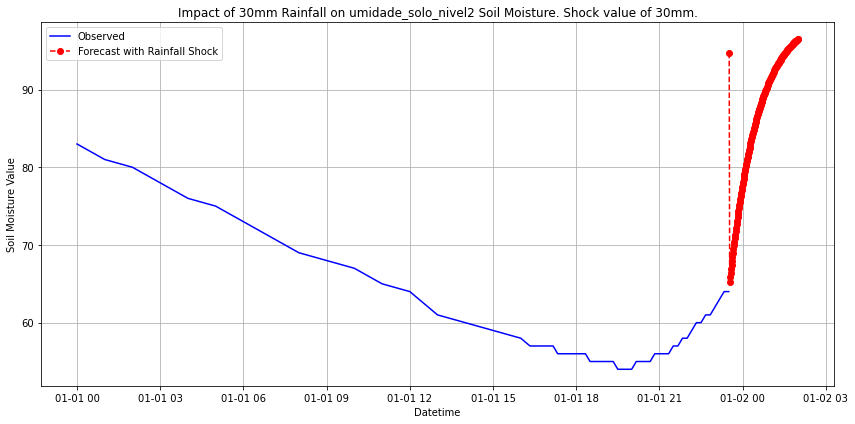

In [30]:
model_fit, forecast_with_shock = manual_rainfall_shock_simulation_refined_v2('newData.csv', 'umidade_solo_nivel2')


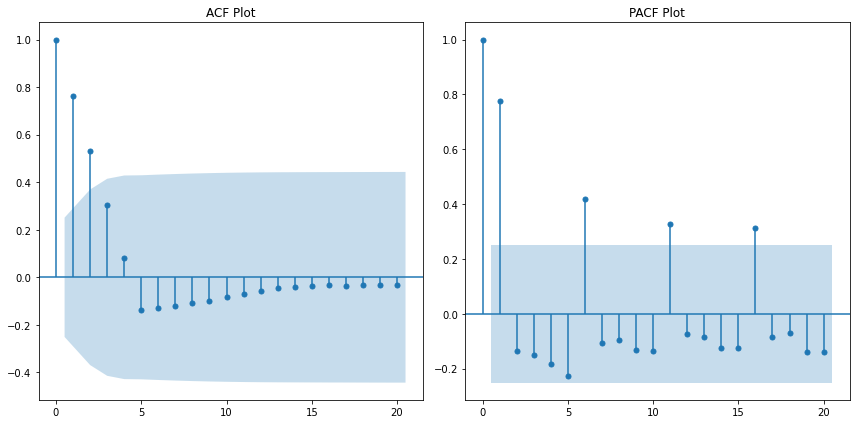

Best order based on AIC: (1, 0, 0)
Best order based on BIC: (1, 0, 0)
Best order based on average rank: (2, 0, 2)
(2, 0, 2)


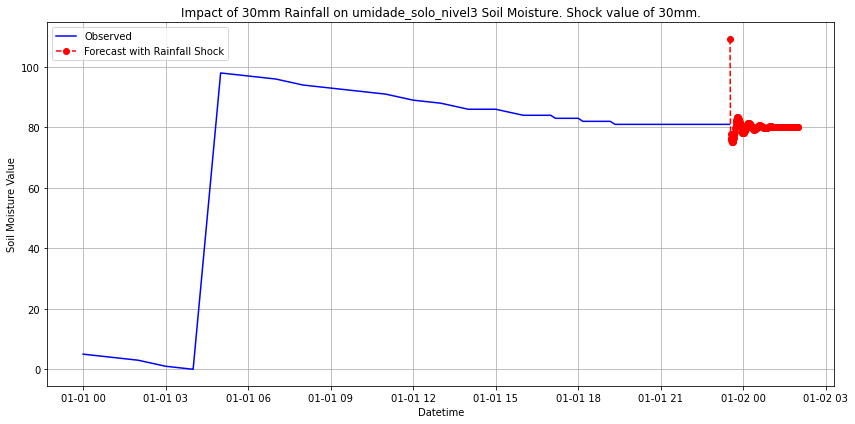

In [31]:
model_fit, forecast_with_shock = manual_rainfall_shock_simulation_refined_v2('newData.csv', 'umidade_solo_nivel3')


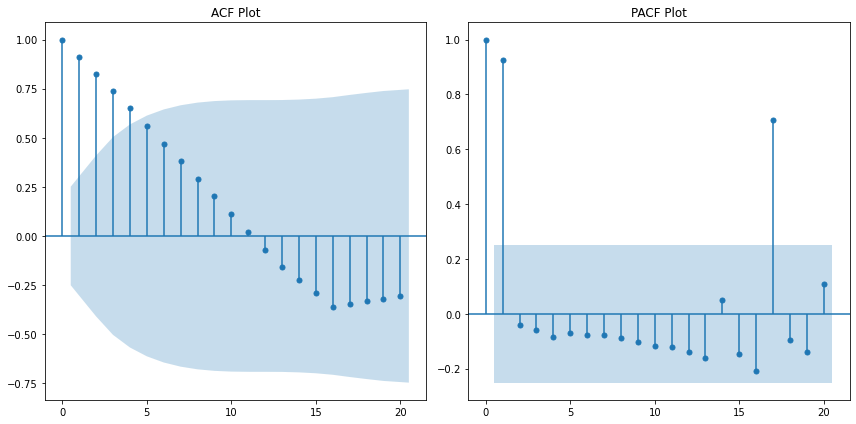

Best order based on AIC: (0, 1, 0)
Best order based on BIC: (0, 1, 0)
Best order based on average rank: (0, 1, 0)
(0, 1, 0)


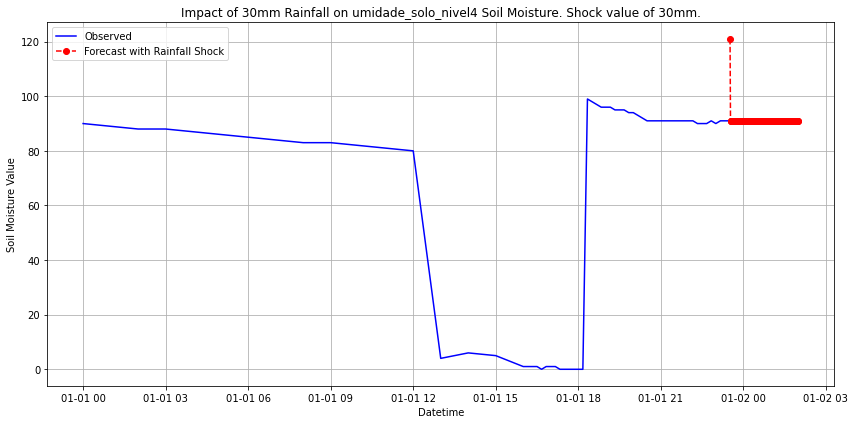

In [32]:
model_fit, forecast_with_shock = manual_rainfall_shock_simulation_refined_v2('newData.csv', 'umidade_solo_nivel4')


In [1]:
model_fit, forecast_with_shock = manual_rainfall_shock_simulation_refined_v2('newData.csv', 'umidade_solo_nivel5')

NameError: name 'manual_rainfall_shock_simulation_refined_v2' is not defined

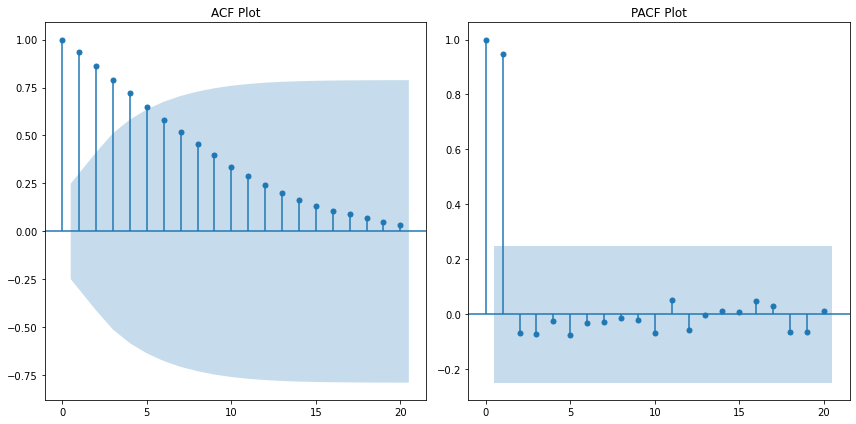

Best order based on AIC: (2, 0, 2)
Best order based on BIC: (2, 0, 2)
Best order based on average rank: (2, 0, 2)
(2, 0, 2)


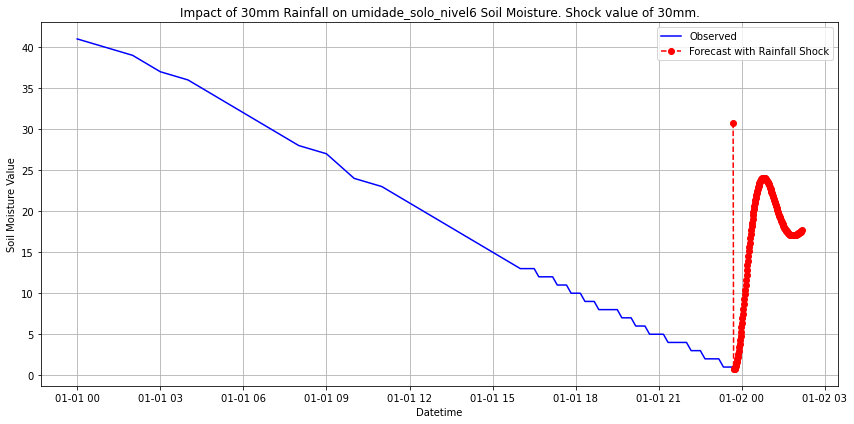

In [34]:
model_fit, forecast_with_shock = manual_rainfall_shock_simulation_refined_v2('newData.csv', 'umidade_solo_nivel6')


#### Understand the new data to be considered in meeting, review cross sectional implementation with Cassiano.